In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
import pickle

In [53]:
# Load data
df = pd.read_csv("4-US_Regional_Sales_Data.csv")

In [54]:
df.shape

(7991, 16)

In [55]:
df.isnull().sum()

OrderNumber         0
Sales Channel       0
WarehouseCode       0
ProcuredDate        0
OrderDate           0
ShipDate            0
DeliveryDate        0
CurrencyCode        0
_SalesTeamID        0
_CustomerID         0
_StoreID            0
_ProductID          0
Order Quantity      0
Discount Applied    0
Unit Cost           0
Unit Price          0
dtype: int64

In [56]:
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.08,"$1,001.18","$1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/2018,USD,14,20,196,27,3,0.08,"$3,348.66","$3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/2018,USD,21,16,213,16,1,0.05,$781.22,"$1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/2018,7/6/2018,USD,28,48,107,23,8,0.08,"$1,464.69","$2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/2018,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.10,"$1,476.14","$1,822.40"


Feature Engineering

In [57]:
# Drop irrelevant columns
df = df.drop(columns=['OrderNumber', 'CurrencyCode'])


In [58]:
# Clean currency columns
df['Unit Cost'] = df['Unit Cost'].apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float)
df['Unit Price'] = df['Unit Price'].apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float)

In [59]:
# Convert date columns
date_cols = ["ProcuredDate", "OrderDate", "ShipDate", "DeliveryDate"]
for feature in date_cols:
    df[feature] = pd.to_datetime(df[feature], dayfirst=True, errors='coerce')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20172\3837432441.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[feature] = pd.to_datetime(df[feature], dayfirst=True, errors='coerce')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20172\3837432441.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[feature] = pd.to_datetime(df[feature], dayfirst=True, errors='coerce')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20172\3837432441.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[feature] = pd.to_datetime(df[feature], dayfirst=True, errors='coerce')
C:\Users\Lenovo\

In [60]:
# Create duration features
df["Order_to_Ship_Days"] = (df["ShipDate"] - df["OrderDate"]).dt.days
df["Ship_to_Delivery_Days"] = (df["DeliveryDate"] - df["ShipDate"]).dt.days
df["Order_to_Delivery_Days"] = (df["DeliveryDate"] - df["OrderDate"]).dt.days
df = df.drop(columns=date_cols)

In [61]:
# Revenue
df["Total Revenue"] = df["Order Quantity"] * df["Unit Price"] * (1 - df["Discount Applied"])

In [62]:
df.head()

,Sales Channel,WarehouseCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price,Order_to_Ship_Days,Ship_to_Delivery_Days,Order_to_Delivery_Days,Total Revenue
0,In-Store,WARE-UHY1004,6,15,259,12,5,0.08,1001.18,1963.1,14,5,19,9030.260
1,Online,WARE-NMK1003,14,20,196,27,3,0.08,3348.66,3939.6,22,10,32,10873.296
2,Distributor,WARE-UHY1004,21,16,213,16,1,0.05,781.22,1775.5,21,10,31,1686.725
3,Wholesale,WARE-NMK1003,28,48,107,23,8,0.08,1464.69,2324.9,2,5,7,17111.264
4,Distributor,WARE-NMK1003,22,49,111,26,8,0.10,1476.14,1822.4,16,10,26,13121.280


In [63]:
#Unique Values of all features
for feature in df.iloc[:,:-1]:
    print(feature,": ",df[feature].unique(),"\n\n")

Sales Channel :  ['In-Store' 'Online' 'Distributor' 'Wholesale'] 


WarehouseCode :  ['WARE-UHY1004' 'WARE-NMK1003' 'WARE-PUJ1005' 'WARE-XYS1001'
 'WARE-MKL1006' 'WARE-NBV1002'] 


_SalesTeamID :  [ 6 14 21 28 22 12 10  4 23  8  9  5 25  2  7 24 18 20 13 19 17 26 11 15
 16 27  3  1] 


_CustomerID :  [15 20 16 48 49 21 14  9 33 36 17 32 11 10 30  5 23 46 40 19 22 29 35 42
  2 28 34 26 24 18  3 13  4 25  8 47  6 38  1  7 27 44 12 50 43 37 41 31
 45 39] 


_StoreID :  [259 196 213 107 111 285   6 280 299 261  17 152 317 291 138 354 320  21
 349 134 193 282  20 218 173 110 229 238  97 103 305 303 217 362 335  84
 256 360  90  40 367 249 212  37  38 294 105 109 141 148  59  60 151 262
 120 233  77  69 215  30 169 333  96 289 140 338 232 231 158  36 206 255
 336 307   9 200 337 185 189 170 130 149  99  23 144 180  58 175  95 199
 345 241 186 288 277 219 306   7  78  28  39 122  48   1 198 242 304  31
  71 250 167 132  56 341 195  33 279 181  63 163 101 321 276 248  12 119
 290  87 177  94 1

In [64]:
df.columns

Index(['Sales Channel', 'WarehouseCode', '_SalesTeamID', '_CustomerID',
       '_StoreID', '_ProductID', 'Order Quantity', 'Discount Applied',
       'Unit Cost', 'Unit Price', 'Order_to_Ship_Days',
       'Ship_to_Delivery_Days', 'Order_to_Delivery_Days', 'Total Revenue'],
      dtype='object')

Sales Channel, WareHouseCode & ID are categorical. Rest are Numerical

In [65]:
cat_cols=['Sales Channel', 'WarehouseCode', '_SalesTeamID', '_CustomerID',
       '_StoreID', '_ProductID']

num_cols=['Order Quantity', 'Discount Applied',
       'Unit Cost', 'Unit Price', 'Order_to_Ship_Days',
       'Ship_to_Delivery_Days', 'Order_to_Delivery_Days','Total Revenue']

EDA

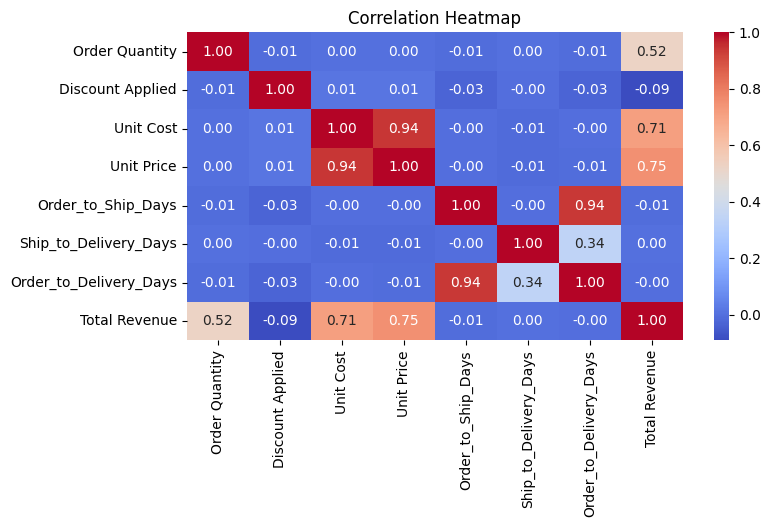

In [66]:
# Correlation heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Unit Price & Unit Cost have multicollinearity but dropping them results in poor performance. So keep them.

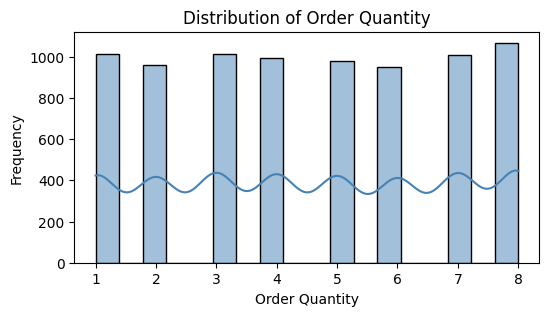

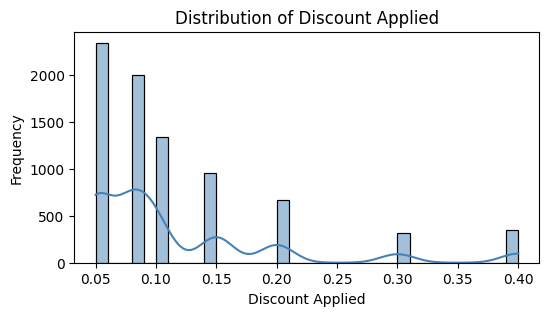

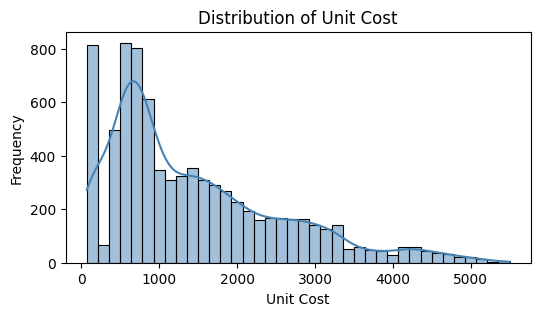

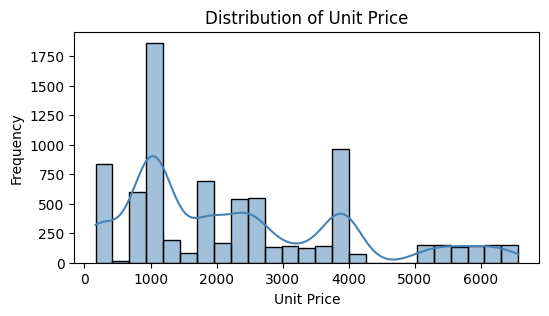

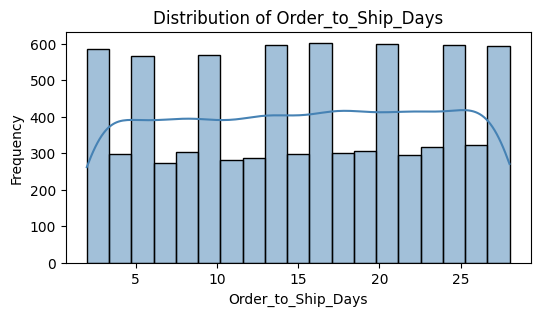

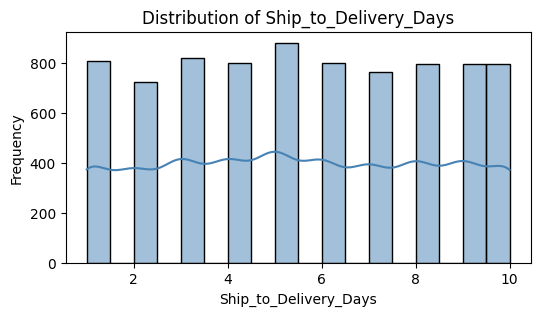

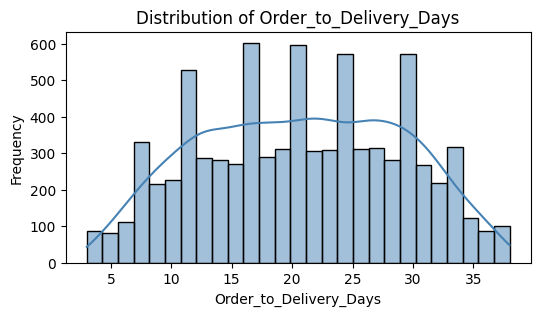

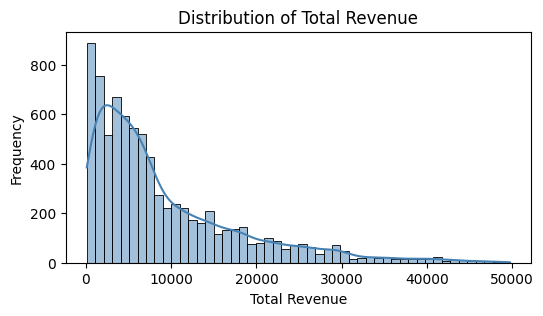

In [67]:
for feature in num_cols:
    plt.figure(figsize=(6, 3))  
    sns.histplot(df[feature], kde=True, color='steelblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Random Forest can handle skewness, no log transformation needed

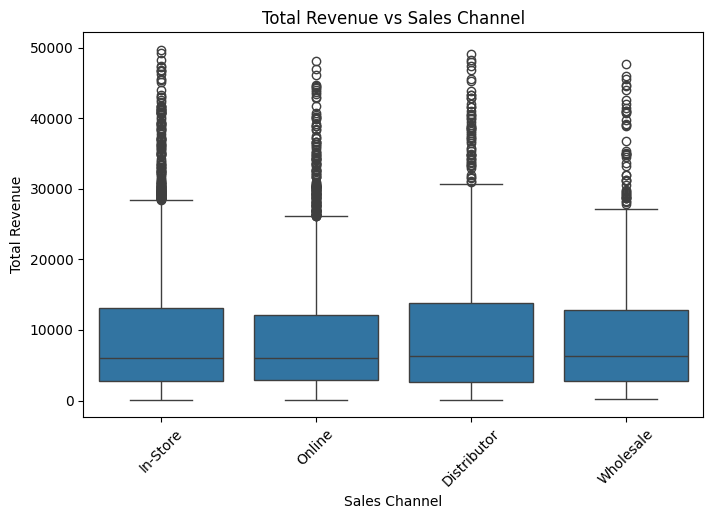

In [68]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Sales Channel", y="Total Revenue", data=df)
plt.title("Total Revenue vs Sales Channel")
plt.xticks(rotation=45)
plt.show()

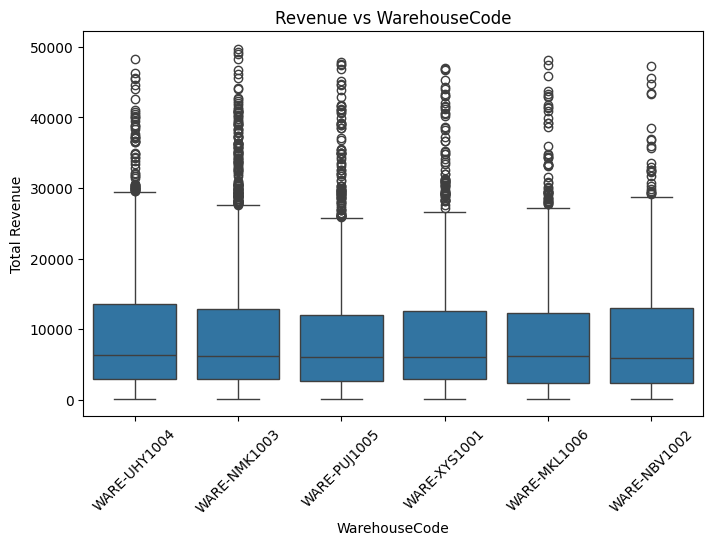

In [69]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="WarehouseCode", y="Total Revenue", data=df)
plt.title("Revenue vs WarehouseCode")
plt.xticks(rotation=45)
plt.show()

Lots of Outliers but important to keep them for important business transactions. Also removing them results poor performance

In [70]:
# Encode categorical
df = pd.get_dummies(df, columns=["Sales Channel", "WarehouseCode"], drop_first=True)

ID are not OneHotEncoded for High Cardinality.

ID are TargetEncoded

In [71]:
target_col = "Total Revenue"
id_cols = ['_SalesTeamID', '_CustomerID', '_StoreID', '_ProductID']
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [72]:
target_encoding_maps = {}

In [73]:
for col in id_cols:
    df[f'{col}_TE'] = np.nan
    full_means = df.groupby(col)[target_col].mean()
    target_encoding_maps[col] = full_means.to_dict()  # Save mapping

    for train_idx, val_idx in kfold.split(df):
        train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
        means = train_fold.groupby(col)[target_col].mean()
        df.loc[df.index[val_idx], f'{col}_TE'] = df.loc[df.index[val_idx], col].map(means)


In [74]:
# Drop original high-cardinality columns
df.drop(columns=id_cols, inplace=True)

In [75]:
# Save the target encoding mappings for inference later
with open("target_encoding_maps.pkl", "wb") as f:
    pickle.dump(target_encoding_maps, f)

In [76]:
df.head()

,Order Quantity,Discount Applied,Unit Cost,Unit Price,Order_to_Ship_Days,Ship_to_Delivery_Days,Order_to_Delivery_Days,Total Revenue,Sales Channel_In-Store,Sales Channel_Online,Sales Channel_Wholesale,WarehouseCode_WARE-NBV1002,WarehouseCode_WARE-NMK1003,WarehouseCode_WARE-PUJ1005,WarehouseCode_WARE-UHY1004,WarehouseCode_WARE-XYS1001,_SalesTeamID_TE,_CustomerID_TE,_StoreID_TE,_ProductID_TE
0,5,0.08,1001.18,1963.1,14,5,19,9030.260,True,False,False,False,False,False,True,False,9055.132674,9651.483412,9758.439929,8899.503757
1,3,0.08,3348.66,3939.6,22,10,32,10873.296,False,True,False,False,True,False,False,False,9126.084676,8064.394948,8733.743125,8591.113221
2,1,0.05,781.22,1775.5,21,10,31,1686.725,False,False,False,False,False,False,True,False,9709.143604,9664.878257,12680.781800,9530.659573
3,8,0.08,1464.69,2324.9,2,5,7,17111.264,False,False,True,False,True,False,False,False,8974.299925,8590.286681,8288.941077,10967.331957
4,8,0.10,1476.14,1822.4,16,10,26,13121.280,False,False,False,False,True,False,False,False,9519.656668,8093.379458,10936.166364,7821.399368


In [77]:
# Split features and target
X = df.drop("Total Revenue", axis=1)
y = df["Total Revenue"]

In [78]:
# Save feature column for using in streamlit later
feature_columns = list(X.columns)

with open("feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
X.head()

,Order Quantity,Discount Applied,Unit Cost,Unit Price,Order_to_Ship_Days,Ship_to_Delivery_Days,Order_to_Delivery_Days,Sales Channel_In-Store,Sales Channel_Online,Sales Channel_Wholesale,WarehouseCode_WARE-NBV1002,WarehouseCode_WARE-NMK1003,WarehouseCode_WARE-PUJ1005,WarehouseCode_WARE-UHY1004,WarehouseCode_WARE-XYS1001,_SalesTeamID_TE,_CustomerID_TE,_StoreID_TE,_ProductID_TE
0,5,0.08,1001.18,1963.1,14,5,19,True,False,False,False,False,False,True,False,9055.132674,9651.483412,9758.439929,8899.503757
1,3,0.08,3348.66,3939.6,22,10,32,False,True,False,False,True,False,False,False,9126.084676,8064.394948,8733.743125,8591.113221
2,1,0.05,781.22,1775.5,21,10,31,False,False,False,False,False,False,True,False,9709.143604,9664.878257,12680.781800,9530.659573
3,8,0.08,1464.69,2324.9,2,5,7,False,False,True,False,True,False,False,False,8974.299925,8590.286681,8288.941077,10967.331957
4,8,0.10,1476.14,1822.4,16,10,26,False,False,False,False,True,False,False,False,9519.656668,8093.379458,10936.166364,7821.399368


In [81]:
y.head()

0     9030.260
1    10873.296
2     1686.725
3    17111.264
4    13121.280
Name: Total Revenue, dtype: float64

In [82]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [83]:
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

In [84]:
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_cv_r2 = cross_val_score(clone(lr), X_train, y_train, cv=5, scoring='r2').mean()

In [85]:
lr_mae = mean_absolute_error(y_test, lr_test_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))

In [86]:
print("Linear Regression Evaluation:")
print(f"Train R² : {lr_train_r2:.4f}")
print(f"CV R²    : {lr_cv_r2:.4f}")
print(f"Test R²  : {lr_test_r2:.4f}")
print(f"MAE      : {lr_mae:.2f}")
print(f"RMSE     : {lr_rmse:.2f}")
print("-" * 40)

Linear Regression Evaluation:
Train R² : 0.8477
CV R²    : 0.8465
Test R²  : 0.8442
MAE      : 2512.11
RMSE     : 3512.04
----------------------------------------


Random Forest

In [87]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [88]:
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

In [89]:
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_cv_r2 = cross_val_score(clone(rf), X_train, y_train, cv=5, scoring='r2').mean()

In [90]:
rf_mae = mean_absolute_error(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

In [91]:
print("Random Forest Evaluation:")
print(f"Train R² : {rf_train_r2:.4f}")
print(f"CV R²    : {rf_cv_r2:.4f}")
print(f"Test R²  : {rf_test_r2:.4f}")
print(f"MAE      : {rf_mae:.2f}")
print(f"RMSE     : {rf_rmse:.2f}")
print("-" * 40)

Random Forest Evaluation:
Train R² : 0.9998
CV R²    : 0.9979
Test R²  : 0.9984
MAE      : 151.72
RMSE     : 351.06
----------------------------------------


PLOTS

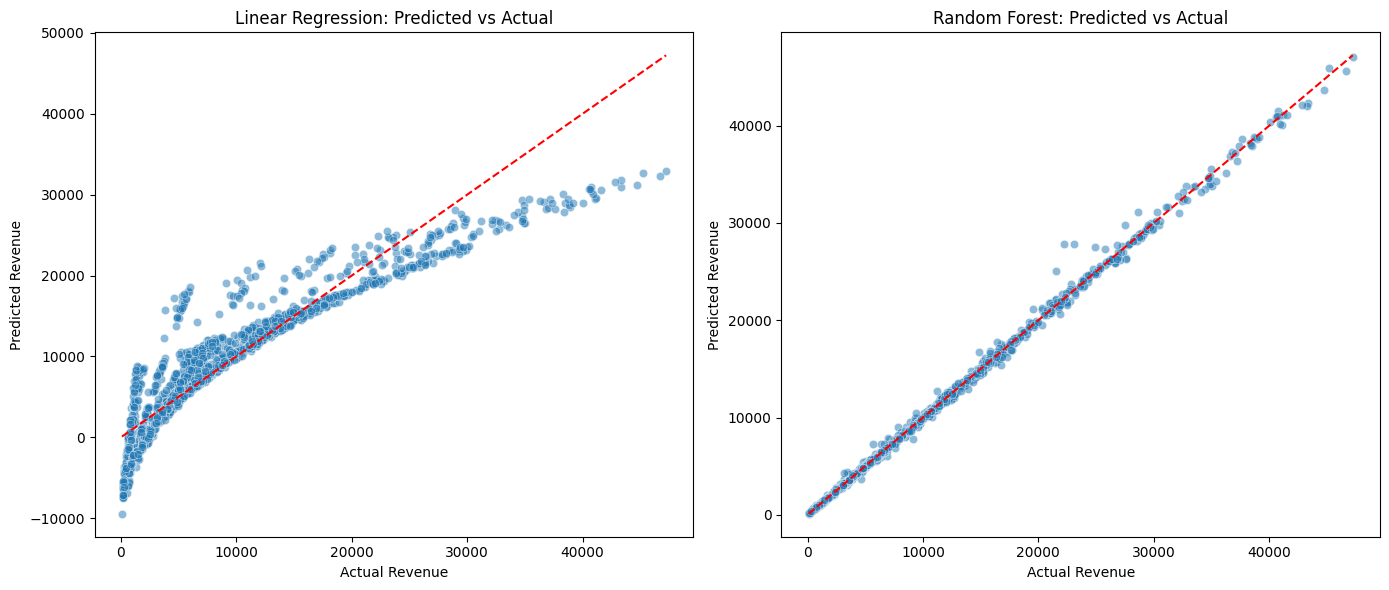

In [92]:
# Scatter plots: Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression: Predicted vs Actual")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest: Predicted vs Actual")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")

plt.tight_layout()
plt.show()

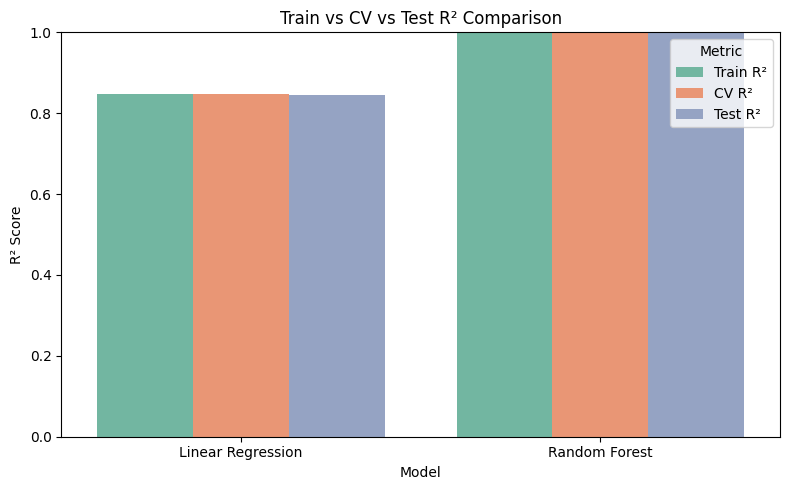

In [93]:
# Bar plot: R² Comparison
r2_scores = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "Train R²": [lr_train_r2, rf_train_r2],
    "CV R²": [lr_cv_r2, rf_cv_r2],
    "Test R²": [lr_test_r2, rf_test_r2]
}).melt(id_vars="Model", var_name="Metric", value_name="R² Score")

plt.figure(figsize=(8, 5))
sns.barplot(data=r2_scores, x="Model", y="R² Score", hue="Metric", palette="Set2")
plt.title("Train vs CV vs Test R² Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

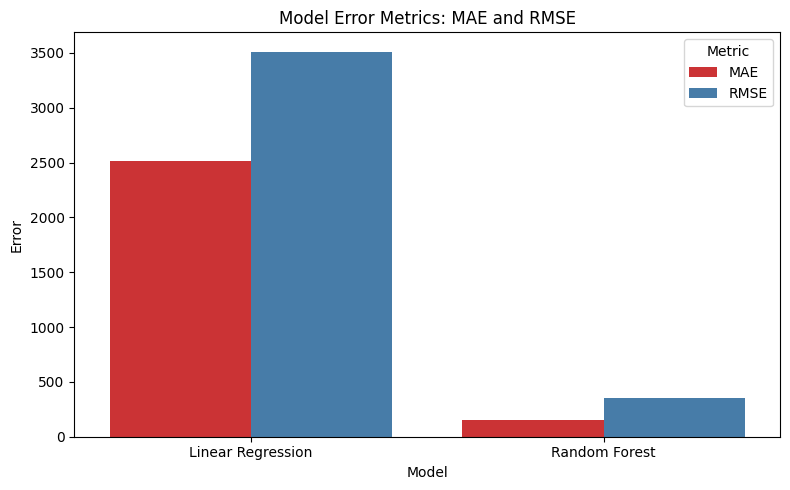

In [94]:
# Bar plot: Error Metrics
error_metrics = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [lr_mae, rf_mae],
    "RMSE": [lr_rmse, rf_rmse]
}).melt(id_vars="Model", var_name="Metric", value_name="Error")

plt.figure(figsize=(8, 5))
sns.barplot(data=error_metrics, x="Model", y="Error", hue="Metric", palette="Set1")
plt.title("Model Error Metrics: MAE and RMSE")
plt.tight_layout()
plt.show()

Save Model

In [95]:
import pickle

In [96]:
# Save the model
with open('rf_final_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [97]:
df.head()

,Order Quantity,Discount Applied,Unit Cost,Unit Price,Order_to_Ship_Days,Ship_to_Delivery_Days,Order_to_Delivery_Days,Total Revenue,Sales Channel_In-Store,Sales Channel_Online,Sales Channel_Wholesale,WarehouseCode_WARE-NBV1002,WarehouseCode_WARE-NMK1003,WarehouseCode_WARE-PUJ1005,WarehouseCode_WARE-UHY1004,WarehouseCode_WARE-XYS1001,_SalesTeamID_TE,_CustomerID_TE,_StoreID_TE,_ProductID_TE
0,5,0.08,1001.18,1963.1,14,5,19,9030.260,True,False,False,False,False,False,True,False,9055.132674,9651.483412,9758.439929,8899.503757
1,3,0.08,3348.66,3939.6,22,10,32,10873.296,False,True,False,False,True,False,False,False,9126.084676,8064.394948,8733.743125,8591.113221
2,1,0.05,781.22,1775.5,21,10,31,1686.725,False,False,False,False,False,False,True,False,9709.143604,9664.878257,12680.781800,9530.659573
3,8,0.08,1464.69,2324.9,2,5,7,17111.264,False,False,True,False,True,False,False,False,8974.299925,8590.286681,8288.941077,10967.331957
4,8,0.10,1476.14,1822.4,16,10,26,13121.280,False,False,False,False,True,False,False,False,9519.656668,8093.379458,10936.166364,7821.399368
